# Solving chemical equilibrium problems in Python

This post demonstrates how to build a computational model for acid–base titrations using Python and the ChemPy library.

We'll simulate the titration of monoprotic, diprotic, and triprotic acids with sodium hydroxide (NaOH), and visualize the results with titration curves.

In [1]:
import warnings
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from chempy.equilibria import EqSystem

## Building the Chemical Equilibrium System

We programmatically generate equilibrium systems for polyprotic acids using the relationship $K_a = 10^{-pK_a}$ for each successive deprotonation step. The chemical species follow a systematic naming convention:

- Fully protonated: $\text{AcH}_n$ (where $n$ = number of ionizable protons)
- First deprotonation: $\text{AcH}_{n-1}^-$
- Second deprotonation: $\text{AcH}_{n-2}^{2-}$
- And so forth...

The equilibrium system includes:
1. Water autoprotolysis: $\text{H}_2\text{O} \rightleftharpoons \text{H}^+ + \text{OH}^-$
2. Strong base dissociation: $\text{NaOH} \rightarrow \text{Na}^+ + \text{OH}^-$
3. Acid deprotonation steps: $\text{AcH}_j \rightleftharpoons \text{AcH}_{j-1}^- + \text{H}^+$

This approach keeps the model compact while capturing essential acid–base chemistry.

In [3]:
def build_system(*pKas):
    eqs = [
        "H2O = H+ + OH-; 10**-14/55.4",
        "NaOH = Na+ + OH-; 10**100.",
    ]
    n = len(pKas)

    def species(j):  # j = number of deprotonations (0..n)
        hcount = n - j
        name = "Ac"
        if hcount > 0:
            name += "H" * hcount
        if j > 0:
            name += f"{-j:+}"  # numeric charge, e.g. -1, -2
        return name

    for j, pKa in enumerate(pKas):
        left = species(j)
        right = species(j + 1) + " + H+"
        eqs.append(f"{left} = {right}; 10**-{pKa}")

    return EqSystem.from_string("\n".join(eqs))

### Testing the System Builder

Let's verify our system builder works correctly by creating a triprotic acid with $pK_a$ values of 1, 2, and 3:

In [4]:
build_system(1, 2, 3)

## Computing Equilibrium Concentrations

For each titration point, we solve the complete equilibrium system starting with:
- 1.0 M fully protonated acid ($\text{AcH}_n$)
- Pure water (55.4 M $\text{H}_2\text{O}$)
- Variable amount of added NaOH

The `EqSystem.root` method solves the nonlinear system of mass-action equations to find equilibrium concentrations. We extract $[\text{H}^+]$ to calculate pH = $-\log_{10}[\text{H}^+]$.

In [ ]:
def compute_equilibrium(*pKas, added_base):
    # number of dissociable protons
    n_forms = len(pKas)
    system = build_system(*pKas)

    # fully protonated species name must match build_system's pattern: Ac + 'H'*n
    acid_name = "Ac" + "H" * n_forms

    # initial amounts: fully protonated acid, water, and added base
    initial_concentrations = defaultdict(
        float,
        {
            "H2O": 55.4,
            acid_name: 1.0,  # was AcH{n_forms}, which didn't exist in the system
            "NaOH": added_base,
        },
    )

    with warnings.catch_warnings(record=True):
        equilibrium_concentrations, info, sane = system.root(initial_concentrations)

    conc = dict(zip(system.substances, equilibrium_concentrations))
    return conc

## Generating Titration Curves

We simulate a complete titration by sweeping the amount of added NaOH from 0 to $n+1$ equivalents (where $n$ is the number of ionizable protons). At each point, we:

1. Solve for equilibrium concentrations
2. Calculate pH from $[\text{H}^+]$
3. Plot pH vs. titrant concentration

**Note:** This simplified model ignores solution volume changes and ionic strength effects, focusing on qualitative trends in titration behavior and buffer capacity.

In [6]:
def plot(*pKas, label: str | None = None):
    n = len(pKas)
    concentration_titrant = np.linspace(0, n + 1, 100)

    equilibrium_results = [
        compute_equilibrium(*pKas, added_base=conc) for conc in concentration_titrant
    ]

    valid = [
        (cont, res["H+"])
        for cont, res in zip(concentration_titrant, equilibrium_results)
        if res is not None
    ]

    titrant_concentration, proton_concentration = map(np.array, zip(*valid))
    pH = -np.log10(proton_concentration)

    sns.lineplot(x=titrant_concentration, y=pH, label=label)

    plt.ylim(0, 14)
    plt.xlabel("titrant (M)")
    plt.ylabel("pH")

## Monoprotic Acid Titrations

Monoprotic acids have a single ionizable proton with one characteristic $pK_a$ value. The strength of the acid (lower $pK_a$ = stronger acid) determines:
- The initial pH of the solution
- The steepness of the titration curve
- The pH at the equivalence point

We'll compare acids with $pK_a$ values ranging from strong (fluoroacetic acid, $pK_a = 2.6$) to weak (phenol, $pK_a = 10.0$):

In [ ]:
df_acids = [
    ["fluoroacetic acid", 2.586],
    ["benzoic acid", 4.204],
    ["hydrogen sulfide", 7.0],
    ["phenol", 9.99],
]

Generate titration curves for each monoprotic acid:

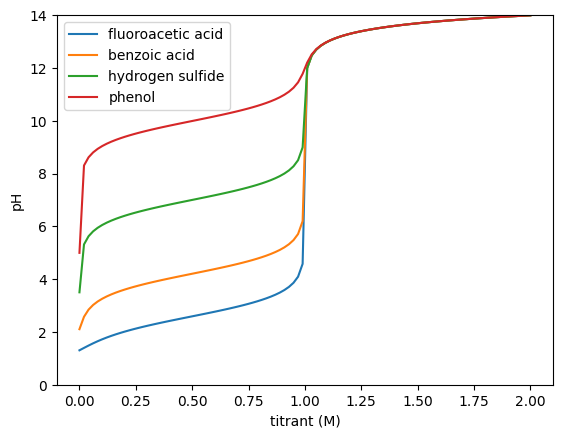

In [22]:
for label, pKa in df_acids:
    plot(pKa, label=label)

## Diprotic Amino Acid Titrations

Amino acids typically exhibit diprotic behavior due to their amino ($-\text{NH}_3^+$) and carboxyl ($-\text{COOH}$) groups. The two $pK_a$ values correspond to:

- $pK_{a1}$: Carboxyl group deprotonation ($\text{COOH} \rightarrow \text{COO}^- + \text{H}^+$)
- $pK_{a2}$: Amino group deprotonation ($\text{NH}_3^+ \rightarrow \text{NH}_2 + \text{H}^+$)

Diprotic titration curves show two equivalence points and one or two buffer regions, depending on the separation between $pK_{a1}$ and $pK_{a2}$. When $\Delta pK_a \geq 3$, the buffer regions are well-separated.

In [25]:
data = [
    ["glycine", 2.34, 9.60, None],
    ["alanine", 2.34, 9.69, None],
    ["valine", 2.32, 9.62, None],
    ["leucine", 2.36, 9.60, None],
    ["isoleucine", 2.36, 9.60, None],
    ["methionine", 2.28, 9.21, None],
    ["proline", 1.99, 10.60, None],
    ["phenylalanine", 1.83, 9.13, None],
    ["tryptophan", 2.38, 9.39, None],
    ["asparagine", 2.02, 8.80, None],
    ["glutamine", 2.17, 9.13, None],
    ["serine", 2.21, 9.15, None],
    ["threonine", 2.09, 9.10, None],
    ["tyrosine", 2.20, 9.11, 10.07],
    ["cysteine", 1.96, 10.28, 8.18],
    ["aspartic acid", 1.88, 9.60, 3.65],
    ["glutamic acid", 2.19, 9.67, 4.25],
    ["lysine", 2.18, 8.95, 10.53],
    ["arginine", 2.17, 9.04, 12.48],
    ["histidine", 1.82, 9.17, 6.00],
]

df_aa = pd.DataFrame(
    data,
    columns=["amino_acid", "pKa1", "pKa2", "pKa3"],
).set_index("amino_acid")
df_aa

,pKa1,pKa2,pKa3
amino_acid,,,
glycine,2.34,9.60,NaN
alanine,2.34,9.69,NaN
valine,2.32,9.62,NaN
leucine,2.36,9.60,NaN
isoleucine,2.36,9.60,NaN
methionine,2.28,9.21,NaN
proline,1.99,10.60,NaN
phenylalanine,1.83,9.13,NaN
tryptophan,2.38,9.39,NaN


Plot titration curves for amino acids with exactly two ionizable groups:

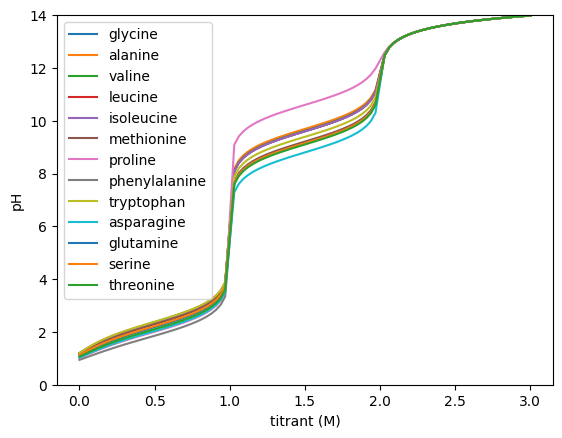

In [45]:
df_aa_dibasic = df_aa[df_aa.notna().sum(axis=1) == 2].iterrows()

for label, acid in df_aa_dibasic:
    pKas = acid.dropna().values
    plot(*pKas, label=label)

## Triprotic Amino Acid Titrations

Some amino acids possess three ionizable groups within the physiological pH range. These include:

- **Acidic amino acids** (Asp, Glu): carboxyl + amino + side chain carboxyl
- **Basic amino acids** (Lys, Arg, His): carboxyl + amino + side chain basic group  
- **Special cases** (Cys, Tyr): carboxyl + amino + side chain with intermediate $pK_a$

Triprotic systems can exhibit up to three equivalence points and three buffer regions when the $pK_a$ values are sufficiently separated ($\Delta pK_a \geq 2-3$).

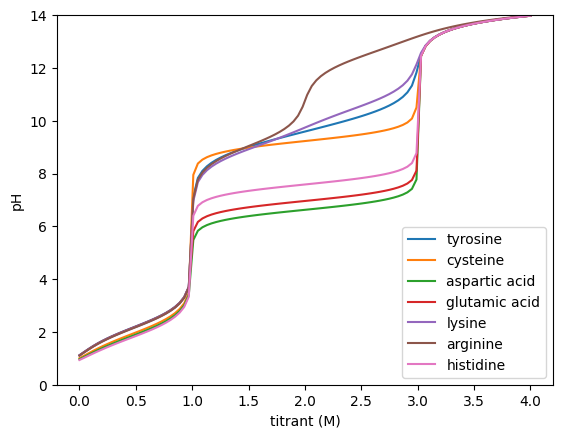

In [46]:
df_aa_tribasic = df_aa[df_aa.notna().sum(axis=1) == 3].iterrows()

for label, acid in df_aa_tribasic:
    pKas = acid.dropna().values
    plot(*pKas, label=label)

## Model Limitations and Extensions

This computational approach provides valuable insights into acid–base equilibria, but several simplifications limit quantitative accuracy:

**Current limitations:**
- Activity coefficients assumed equal to 1 (ideal solution)
- Fixed $K_w = 10^{-14}$ (temperature-independent)
- Neglects ionic strength effects on equilibrium constants
- Ignores volume changes upon mixing

**Potential improvements:**
- Include Debye-Hückel theory for activity corrections
- Add temperature dependence of $K_w$ and $pK_a$ values
- Account for solution volume changes in mass balances
- Consider specific ion interactions in concentrated solutions

Despite these limitations, the model successfully captures the essential features of polyprotic acid titrations and serves as an excellent foundation for understanding buffer chemistry and acid–base equilibria.